In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x, y = cancer.data, cancer.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [3]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_test, y_test)

0.8333333333333334

In [4]:
sgd = SGDClassifier(loss='hinge', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_test, y_test)

0.9385964912280702

In [5]:
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, test_size=0.2, stratify=y_train_all, random_state=42)

In [6]:
len(x_train), len(x_val), len(x_test)

(364, 91, 114)

In [7]:
import numpy as np

In [8]:
class SingleLayer:
    
    def __init__(self, learning_rate=0.1):
        self.w = None
        self.b = None
        self.losses = []
        self.w_history = []
        self.lr = learning_rate
        
    def forpass(self, x):
        z = np.sum(x*self.w) + self.b
        return z
    
    def backprop(self, x, err):
        w_grad = x * err
        b_grad = 1 * err
        return w_grad, b_grad
    
    def activation(self, z):
        a = 1 / (1 + np.exp(-z))
        return a
    
    def fit(self, x, y, epochs=100):
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy())
        np.random.seed(42)
        
        for i in range(epochs):
            loss = 0
            idxs = np.random.permutation(np.arange(len(x)))
            
            for i in idxs:
                z = self.forpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.backprop(x[i], err)
                
                self.w -= w_grad * self.lr
                self.b -= b_grad
                
                self.w_history.append(self.w.copy())
                a = np.clip(a, 1e-10, 1-1e-10)                
                loss += -(y[i]*np.log(a) + (1-y[i])*np.log(1-a))
                
            self.losses.append(loss/len(y))
            
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]        
        return np.array(z) > 0
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

In [9]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


0.9120879120879121

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

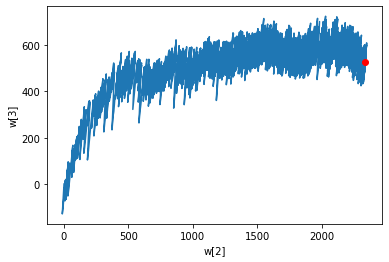

In [16]:
w2, w3 = [], []
for w in layer1.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

In [18]:
class SingleLayer:
    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b
        return z

    def backprop(self, x, err):
        w_grad = x * err          
        b_grad = 1 * err
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None) 
        a = 1 / (1 + np.exp(-z))
        return a
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.w = np.ones(x.shape[1])             
        self.b = 0                               
        self.w_history.append(self.w.copy())     
        np.random.seed(42)                       
        for i in range(epochs):                  
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))
            
            for i in indexes:                      
                z = self.forpass(x[i])             
                a = self.activation(z)             
                err = -(y[i] - a)                  
                w_grad, b_grad = self.backprop(x[i], err)

                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
                self.w -= self.lr * w_grad
                self.b -= self.lr * b_grad

                self.w_history.append(self.w.copy())

                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))

            self.losses.append(loss/len(y) + self.reg_loss())
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]   
        return np.array(z) >= 0               
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)
    
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])     
            a = self.activation(z)         
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

In [21]:
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean) / train_std
x_val_scaled = (x_val - train_mean) / train_std

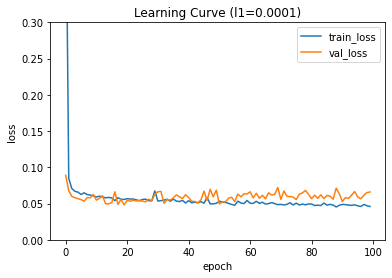

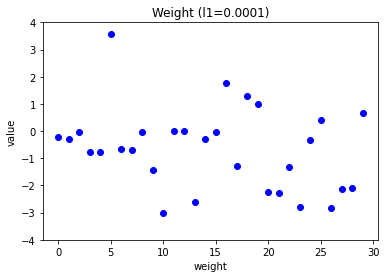

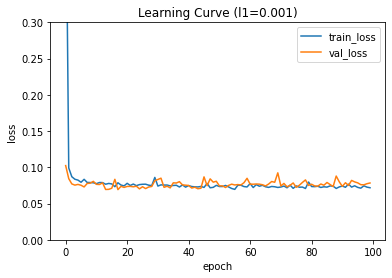

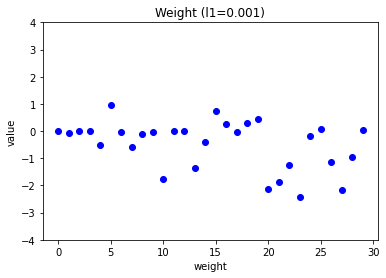

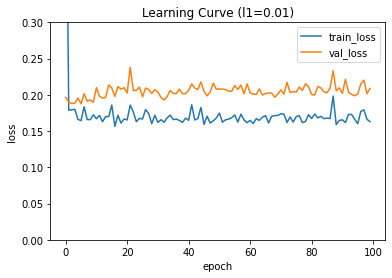

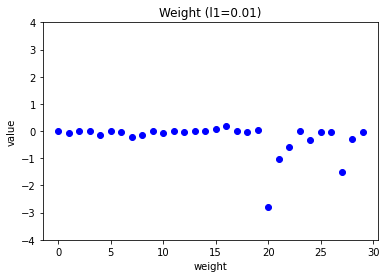

In [22]:
l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_list:
    lyr = SingleLayer(l1=l1)
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)
    
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Learning Curve (l1={})'.format(l1))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()
    
    plt.plot(lyr.w, 'bo')
    plt.title('Weight (l1={})'.format(l1))
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    plt.show()

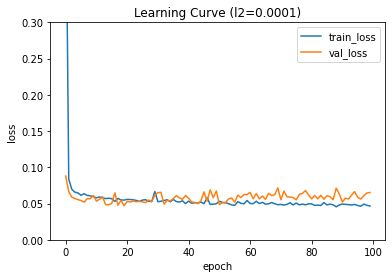

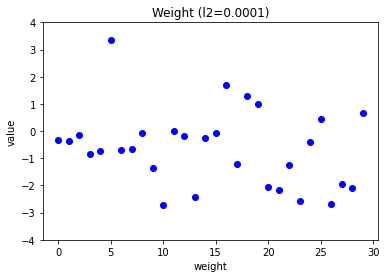

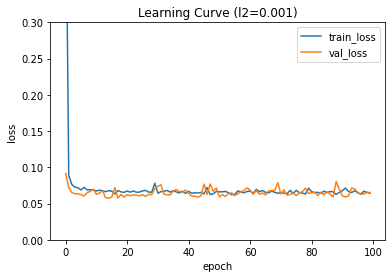

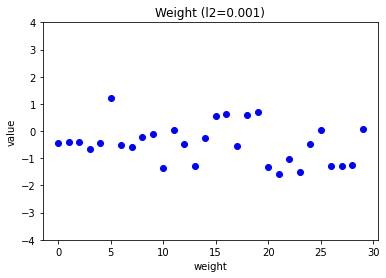

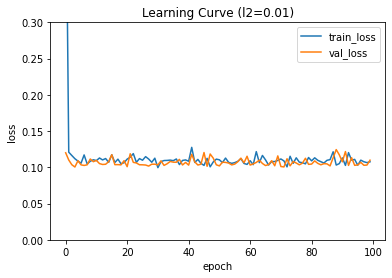

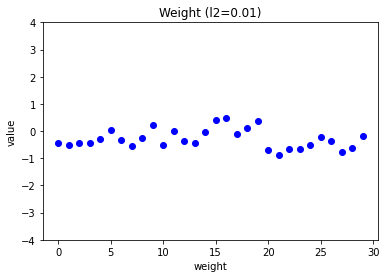

In [23]:
l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
    lyr = SingleLayer(l2=l2)
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)
    
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Learning Curve (l2={})'.format(l2))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()
    
    plt.plot(lyr.w, 'bo')
    plt.title('Weight (l2={})'.format(l2))
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    plt.show()

In [24]:
layer6 = SingleLayer(l2=0.01)
layer6.fit(x_train_scaled, y_train, epochs=50)
layer6.score(x_val_scaled, y_val)

0.989010989010989

In [25]:
from sklearn.model_selection import cross_validate

In [26]:
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
scores = cross_validate(sgd, x_train_all, y_train_all, cv=10)
print(np.mean(scores['test_score']))

0.850096618357488


In [27]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [29]:
pipe = make_pipeline(StandardScaler(), sgd)
scores = cross_validate(pipe, x_train_all, y_train_all, cv=10, return_train_score=True)
print(np.mean(scores['test_score']))

0.9694202898550724


In [30]:
scores

{'fit_time': array([0.00411797, 0.00240612, 0.00270987, 0.00266385, 0.00226617,
        0.00259781, 0.00255895, 0.00281   , 0.00304508, 0.00223017]),
 'score_time': array([0.00053906, 0.00044394, 0.00043225, 0.00034213, 0.00055885,
        0.00039005, 0.00044727, 0.00091505, 0.00037217, 0.00034189]),
 'test_score': array([0.93478261, 0.95652174, 1.        , 0.95652174, 0.91304348,
        1.        , 1.        , 1.        , 1.        , 0.93333333]),
 'train_score': array([0.99266504, 0.98777506, 0.99022005, 0.98777506, 0.98777506,
        0.98536585, 0.98536585, 0.98780488, 0.98292683, 0.98780488])}